<a href="https://colab.research.google.com/github/wei-enwang/space-ham/blob/main/main_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nltk
from nltk.corpus import words
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils import data
from preprocess import WholeData

import models
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/weinwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('words')

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 32
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

[nltk_data] Downloading package words to /home/weinwang/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [9]:
plot_yes = True

# use one dataset for now
train_data_dir = "./data/enron1/"
test_data_dir = "./data/enron2/"
output_dir = "./output/"

# hyperparameters
batch_size = 64
dropout = 0.5
learning_rate = 1e-4
epochs = 30
max_len = 50

In [4]:
vocab = set([str.lower() for str in words.words()])

train_dataset = WholeData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
test_dataset = WholeData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
w2idx = train_dataset.src_v2id

embed = utils.load_pretrained_vectors(w2idx, "fastText/crawl-300d-2M.vec")
embed = torch.tensor(embed)

Loading pretrained vectors...
234378


0it [00:00, ?it/s]

There are 75835 / 234379 pretrained vectors found.


In [10]:
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                   num_workers=8, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=8, pin_memory=True, drop_last=True)


In [11]:
model = models.spam_lstm(pretrained_embedding=embed, dropout=dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
opt = Adam(model.parameters(), lr=learning_rate)

Using pretrained vectors...


  3%|▎         | 1/30 [00:06<03:08,  6.51s/it]

Epoch 0
-------------------------------
Training loss: 0.648501, avg accuracy: 0.425169
Testing loss: 0.557107, avg accuracy: 0.745021


  7%|▋         | 2/30 [00:13<03:02,  6.51s/it]

Epoch 1
-------------------------------
Training loss: 0.510950, avg accuracy: 0.753710
Testing loss: 0.371646, avg accuracy: 0.769231


 10%|█         | 3/30 [00:19<02:55,  6.51s/it]

Epoch 2
-------------------------------
Training loss: 0.291759, avg accuracy: 0.915524
Testing loss: 0.318530, avg accuracy: 0.854052


 13%|█▎        | 4/30 [00:26<02:49,  6.53s/it]

Epoch 3
-------------------------------
Training loss: 0.208693, avg accuracy: 0.945513
Testing loss: 0.363865, avg accuracy: 0.834821


 17%|█▋        | 5/30 [00:32<02:43,  6.54s/it]

Epoch 4
-------------------------------
Training loss: 0.149744, avg accuracy: 0.952650
Testing loss: 0.294293, avg accuracy: 0.874657


 20%|██        | 6/30 [00:39<02:36,  6.53s/it]

Epoch 5
-------------------------------
Training loss: 0.114540, avg accuracy: 0.965233
Testing loss: 0.306989, avg accuracy: 0.870536


 23%|██▎       | 7/30 [00:45<02:30,  6.53s/it]

Epoch 6
-------------------------------
Training loss: 0.110153, avg accuracy: 0.964655
Testing loss: 0.341250, avg accuracy: 0.866071


 27%|██▋       | 8/30 [00:52<02:23,  6.53s/it]

Epoch 7
-------------------------------
Training loss: 0.113126, avg accuracy: 0.964417
Testing loss: 0.343429, avg accuracy: 0.877404


 30%|███       | 9/30 [00:58<02:17,  6.54s/it]

Epoch 8
-------------------------------
Training loss: 0.091477, avg accuracy: 0.973483
Testing loss: 0.344743, avg accuracy: 0.881696


 33%|███▎      | 10/30 [01:05<02:10,  6.53s/it]

Epoch 9
-------------------------------
Training loss: 0.083085, avg accuracy: 0.977342
Testing loss: 0.325594, avg accuracy: 0.890797


 37%|███▋      | 11/30 [01:11<02:04,  6.53s/it]

Epoch 10
-------------------------------
Training loss: 0.074662, avg accuracy: 0.980042
Testing loss: 0.355544, avg accuracy: 0.882383


 40%|████      | 12/30 [01:18<01:57,  6.53s/it]

Epoch 11
-------------------------------
Training loss: 0.073904, avg accuracy: 0.979567
Testing loss: 0.344456, avg accuracy: 0.898695


 43%|████▎     | 13/30 [01:24<01:51,  6.53s/it]

Epoch 12
-------------------------------
Training loss: 0.069649, avg accuracy: 0.982550
Testing loss: 0.353211, avg accuracy: 0.886161


 47%|████▋     | 14/30 [01:31<01:44,  6.52s/it]

Epoch 13
-------------------------------
Training loss: 0.067355, avg accuracy: 0.983025
Testing loss: 0.332911, avg accuracy: 0.897150


 50%|█████     | 15/30 [01:37<01:38,  6.54s/it]

Epoch 14
-------------------------------
Training loss: 0.067141, avg accuracy: 0.982505
Testing loss: 0.309253, avg accuracy: 0.905391


 53%|█████▎    | 16/30 [01:44<01:31,  6.54s/it]

Epoch 15
-------------------------------
Training loss: 0.063178, avg accuracy: 0.984479
Testing loss: 0.345793, avg accuracy: 0.897321


 57%|█████▋    | 17/30 [01:51<01:25,  6.54s/it]

Epoch 16
-------------------------------
Training loss: 0.058310, avg accuracy: 0.986111
Testing loss: 0.333053, avg accuracy: 0.903331


 60%|██████    | 18/30 [01:57<01:18,  6.54s/it]

Epoch 17
-------------------------------
Training loss: 0.067125, avg accuracy: 0.982253
Testing loss: 0.347493, avg accuracy: 0.894918


 63%|██████▎   | 19/30 [02:04<01:12,  6.55s/it]

Epoch 18
-------------------------------
Training loss: 0.063125, avg accuracy: 0.984093
Testing loss: 0.321697, avg accuracy: 0.904705


 67%|██████▋   | 20/30 [02:10<01:05,  6.55s/it]

Epoch 19
-------------------------------
Training loss: 0.053210, avg accuracy: 0.987847
Testing loss: 0.386443, avg accuracy: 0.880666


 70%|███████   | 21/30 [02:17<00:58,  6.54s/it]

Epoch 20
-------------------------------
Training loss: 0.053296, avg accuracy: 0.987996
Testing loss: 0.346046, avg accuracy: 0.902644


 73%|███████▎  | 22/30 [02:23<00:52,  6.55s/it]

Epoch 21
-------------------------------
Training loss: 0.056924, avg accuracy: 0.986259
Testing loss: 0.344040, avg accuracy: 0.894231


 77%|███████▋  | 23/30 [02:30<00:45,  6.55s/it]

Epoch 22
-------------------------------
Training loss: 0.052110, avg accuracy: 0.988619
Testing loss: 0.375615, avg accuracy: 0.890453


 80%|████████  | 24/30 [02:36<00:39,  6.54s/it]

Epoch 23
-------------------------------
Training loss: 0.051176, avg accuracy: 0.988574
Testing loss: 0.338388, avg accuracy: 0.903846


 83%|████████▎ | 25/30 [02:43<00:32,  6.55s/it]

Epoch 24
-------------------------------
Training loss: 0.050388, avg accuracy: 0.988812
Testing loss: 0.388447, avg accuracy: 0.884615


 87%|████████▋ | 26/30 [02:49<00:26,  6.54s/it]

Epoch 25
-------------------------------
Training loss: 0.050278, avg accuracy: 0.988426
Testing loss: 0.425878, avg accuracy: 0.868990


 90%|█████████ | 27/30 [02:56<00:19,  6.54s/it]

Epoch 26
-------------------------------
Training loss: 0.059098, avg accuracy: 0.985295
Testing loss: 0.367301, avg accuracy: 0.890453


 93%|█████████▎| 28/30 [03:03<00:13,  6.54s/it]

Epoch 27
-------------------------------
Training loss: 0.051803, avg accuracy: 0.988040
Testing loss: 0.441520, avg accuracy: 0.863668


 97%|█████████▋| 29/30 [03:09<00:06,  6.54s/it]

Epoch 28
-------------------------------
Training loss: 0.061221, avg accuracy: 0.984627
Testing loss: 0.371569, avg accuracy: 0.914320


100%|██████████| 30/30 [03:16<00:00,  6.54s/it]

Epoch 29
-------------------------------
Training loss: 0.064892, avg accuracy: 0.984330
Testing loss: 0.355359, avg accuracy: 0.900240


Final testing loss: 0.352726, testing accuracy: 0.900927
F1 score: 0.931578 Precision: 0.959453, Recall: 0.905278


(0.06489239431871677, 0.35272562765813137)

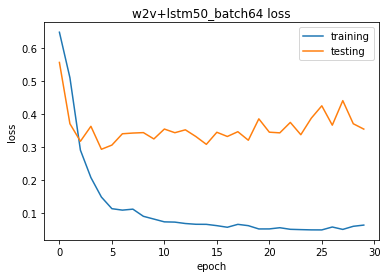

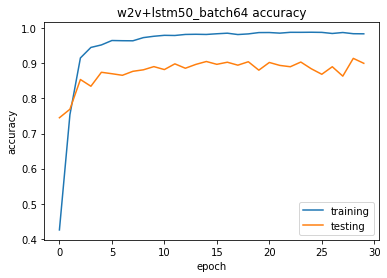

In [12]:
utils.train_test_scheme(train_dataloader, test_dataloader, model, loss_fn, opt, 
                        task_name="w2v+lstm50_batch64", epochs=epochs, 
                        vis=plot_yes, print_every=1, img_dir=output_dir)



In [13]:
torch.save(model.state_dict(), output_dir+"w2v_lstmlen50_batch64.pt")